<a href="https://colab.research.google.com/github/atloveu1226/CMIT2024/blob/main/hw6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 *When importing **'gym'** package, I found that I cannot print our map in a matrix way, so I upgrade **'gym'** and solve this problem.*

In [ ]:
!pip install gym  --upgrade


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import gym
import gym.spaces

import time

In [ ]:
env = gym.make("FrozenLake-v1", is_slippery=False, map_name="4x4", render_mode="ansi")
print("Action space: ", env.action_space)
print("Observation space: ", env.observation_space)

Action space:  Discrete(4)
Observation space:  Discrete(16)


In [ ]:
env.reset()
print(env.render())


SFFF
FHFH
FFFH
HFFG



*This is the part we define the location, the index of **'1'** represents the corresponding location*

In [ ]:
class MyWrapper(gym.ObservationWrapper):
    def __init__(self, env):
       super(MyWrapper, self).__init__(env)
       self.observation_space = gym.spaces.Box(0.0, 1.0, (env.observation_space.n,), dtype=np.float32)
          #Our observations/states will be a vector of 16 reals in [0,1]

    def observation(self, observation): #the state vector contains a 1 at index describing the former state
        r = np.copy(self.observation_space.low)
        r[observation] = 1.0
        return r

env = MyWrapper(env)

*Here we study the capability of two activation functions*

In [ ]:
obs_size = env.observation_space.shape[0] # 16
n_actions = env.action_space.n  # 4
HIDDEN_SIZE = 128 #128

net1= nn.Sequential(
            nn.Linear(obs_size, HIDDEN_SIZE),
            nn.ReLU(),
            #nn.Sigmoid(),
            nn.Linear(HIDDEN_SIZE, n_actions)
        )

objective = nn.CrossEntropyLoss() #quite standard for classification tasks
optimizer1 = optim.Adam(params=net1.parameters(), lr=0.001)

In [ ]:
sm = nn.Softmax(dim=1) #Softmax converts the 4-dimensional output vector to a probability distribution

def select_action1(state):
        state_t = torch.FloatTensor([state])
        act_probs_t = sm(net1(state_t))
        act_probs = act_probs_t.data.numpy()[0]
        action = np.random.choice(len(act_probs), p=act_probs) #chooses randomly one of the 4 actions according to the probabilities returned by the net
        return action

In [ ]:
obs_size = env.observation_space.shape[0] # 16
n_actions = env.action_space.n  # 4
HIDDEN_SIZE = 128 #128

net2= nn.Sequential(
            nn.Linear(obs_size, HIDDEN_SIZE),
            #nn.ReLU(),
            nn.Sigmoid(),
            nn.Linear(HIDDEN_SIZE, n_actions)
        )

objective = nn.CrossEntropyLoss() #quite standard for classification tasks
optimizer2 = optim.Adam(params=net2.parameters(), lr=0.001)

In [ ]:
sm = nn.Softmax(dim=1) #Softmax converts the 4-dimensional output vector to a probability distribution

def select_action2(state):
        state_t = torch.FloatTensor([state])
        act_probs_t = sm(net2(state_t))
        act_probs = act_probs_t.data.numpy()[0]
        action = np.random.choice(len(act_probs), p=act_probs) #chooses randomly one of the 4 actions according to the probabilities returned by the net
        return action

----------------------------------------------------------------------


In [ ]:
BATCH_SIZE = 100 #100

GAMMA = 0.9

PERCENTILE = 30 #30
REWARD_GOAL = 0.8

from collections import namedtuple  #more readable tuples
Episode = namedtuple('Episode', field_names=['reward', 'steps'])
EpisodeStep = namedtuple('EpisodeStep', field_names=['observation', 'action'])

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
start_time = time.time()

iter1_no = 0
reward_mean = 0
full_batch = []
batch = []
episode_steps = []
episode_reward = 0.0
state,_ = env.reset()
losses1 = []

while reward_mean < REWARD_GOAL:
        action = select_action1(state)
        next_state, reward, episode_is_done, _ , _= env.step(action)

        episode_steps.append(EpisodeStep(observation=state, action=action))
        episode_reward += reward

        #print(episode_steps)

        if episode_is_done: # Episode finished
            batch.append(Episode(reward=episode_reward, steps=episode_steps))


            #print(len(batch))

            next_state,_ = env.reset()
            episode_steps = []
            episode_reward = 0.0

            if len(batch) == BATCH_SIZE: # New set of batches ready --> select "elite"

                #print("Batch full")
                #print(batch)
                #print("\n")
                #input("Press Enter to continue...")


                reward_mean = float(np.mean(list(map(lambda s: s.reward, batch)))) #compute mean reward (lambda is inline function)
                elite_candidates= batch
                #elite_candidates= batch + full_batch
                returnG = list(map(lambda s: s.reward * (GAMMA ** len(s.steps)), elite_candidates))
                reward_bound = np.percentile(returnG, PERCENTILE) #lowest score that is greater than PERCENTILE% of scores in the data set
                                                                  #Keep the highest 100-PERCENTILE %
                #print("Batch finished", returnG, reward_bound)
                #input("Press Enter to continue...")

                train_obs = []
                train_act = []
                elite_batch = []

                for example, discounted_reward in zip(elite_candidates, returnG):
                        if discounted_reward > reward_bound:
                        #if discounted_reward >= reward_bound:
                              train_obs.extend(map(lambda step: step.observation, example.steps))
                              train_act.extend(map(lambda step: step.action, example.steps))
                              elite_batch.append(example)
                full_batch=elite_batch
                state=train_obs
                acts=train_act

                #print(state)
                #print(acts)
                #input("Press Enter to continue...")

                #Do the training
                if len(full_batch) != 0 : # just in case empty during an iteration
                  state_t = torch.FloatTensor(state) #batch of states: [[1.0,0,0,0,0,0,0,0,0,0],[1,...]]
                  acts_t = torch.LongTensor(acts) # batch of actions: [0,2,3,1,..]

                  #print(state_t)
                  #print(acts_t)
                  #input("Press Enter to continue...")
                  optimizer1.zero_grad() #it is good practice to do this, initializing the gradient computations
                  action_scores_t1 = net1(state_t)


                  #print(action_scores_t)
                  #input("Press Enter to continue...")

                  loss_t1 = objective(action_scores_t1, acts_t)
                  loss_t1.backward() #computes the gradients
                  optimizer1.step() #updates the weights according to the gradients
                  print("%d: loss=%.3f, reward_mean=%.3f" % (iter1_no, loss_t1.item(), reward_mean))
                  iter1_no += 1
                  losses1.append(loss_t1.item())
                batch = [] #empty the batch
        state = next_state

print("--- %s seconds ---" % (time.time() - start_time))

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


0: loss=1.356, reward_mean=0.020
1: loss=1.366, reward_mean=0.050
2: loss=1.339, reward_mean=0.010
3: loss=1.315, reward_mean=0.020
4: loss=1.340, reward_mean=0.010
5: loss=1.308, reward_mean=0.010
6: loss=1.363, reward_mean=0.020
7: loss=1.355, reward_mean=0.030
8: loss=1.329, reward_mean=0.030
9: loss=1.325, reward_mean=0.020
10: loss=1.332, reward_mean=0.030
11: loss=1.343, reward_mean=0.050
12: loss=1.308, reward_mean=0.020
13: loss=1.218, reward_mean=0.010
14: loss=1.294, reward_mean=0.030
15: loss=1.344, reward_mean=0.010
16: loss=1.334, reward_mean=0.030
17: loss=1.260, reward_mean=0.080
18: loss=1.325, reward_mean=0.040
19: loss=1.322, reward_mean=0.020
20: loss=1.347, reward_mean=0.040
21: loss=1.282, reward_mean=0.070
22: loss=1.258, reward_mean=0.080
23: loss=1.271, reward_mean=0.040
24: loss=1.299, reward_mean=0.020
25: loss=1.293, reward_mean=0.050
26: loss=1.273, reward_mean=0.010
27: loss=1.360, reward_mean=0.050
28: loss=1.173, reward_mean=0.040
29: loss=1.235, reward_m

In [ ]:
start_time = time.time()

iter2_no = 0
reward_mean = 0
full_batch = []
batch = []
episode_steps = []
episode_reward = 0.0
state,_ = env.reset()
losses2 = []

while reward_mean < REWARD_GOAL:
        action = select_action2(state)
        next_state, reward, episode_is_done, _ , _= env.step(action)

        episode_steps.append(EpisodeStep(observation=state, action=action))
        episode_reward += reward

        #print(episode_steps)

        if episode_is_done: # Episode finished
            batch.append(Episode(reward=episode_reward, steps=episode_steps))


            #print(len(batch))

            next_state,_ = env.reset()
            episode_steps = []
            episode_reward = 0.0

            if len(batch) == BATCH_SIZE: # New set of batches ready --> select "elite"

                #print("Batch full")
                #print(batch)
                #print("\n")
                #input("Press Enter to continue...")


                reward_mean = float(np.mean(list(map(lambda s: s.reward, batch)))) #compute mean reward (lambda is inline function)
                elite_candidates= batch
                #elite_candidates= batch + full_batch
                returnG = list(map(lambda s: s.reward * (GAMMA ** len(s.steps)), elite_candidates))
                reward_bound = np.percentile(returnG, PERCENTILE) #lowest score that is greater than PERCENTILE% of scores in the data set
                                                                  #Keep the highest 100-PERCENTILE %
                #print("Batch finished", returnG, reward_bound)
                #input("Press Enter to continue...")

                train_obs = []
                train_act = []
                elite_batch = []

                for example, discounted_reward in zip(elite_candidates, returnG):
                        if discounted_reward > reward_bound:
                        #if discounted_reward >= reward_bound:
                              train_obs.extend(map(lambda step: step.observation, example.steps))
                              train_act.extend(map(lambda step: step.action, example.steps))
                              elite_batch.append(example)
                full_batch=elite_batch
                state=train_obs
                acts=train_act

                #print(state)
                #print(acts)
                #input("Press Enter to continue...")

                #Do the training
                if len(full_batch) != 0 : # just in case empty during an iteration
                  state_t = torch.FloatTensor(state) #batch of states: [[1.0,0,0,0,0,0,0,0,0,0],[1,...]]
                  acts_t = torch.LongTensor(acts) # batch of actions: [0,2,3,1,..]

                  #print(state_t)
                  #print(acts_t)
                  #input("Press Enter to continue...")
                  optimizer2.zero_grad() #it is good practice to do this, initializing the gradient computations
                  action_scores_t2 = net2(state_t)


                  #print(action_scores_t)
                  #input("Press Enter to continue...")

                  loss_t2 = objective(action_scores_t2, acts_t)
                  loss_t2.backward() #computes the gradients
                  optimizer2.step() #updates the weights according to the gradients
                  print("%d: loss=%.3f, reward_mean=%.3f" % (iter2_no, loss_t2.item(), reward_mean))
                  iter2_no += 1
                  losses2.append(loss_t2.item())
                batch = [] #empty the batch
        state = next_state

print("--- %s seconds ---" % (time.time() - start_time))

0: loss=1.462, reward_mean=0.010
1: loss=1.431, reward_mean=0.010
2: loss=1.386, reward_mean=0.010
3: loss=1.373, reward_mean=0.020
4: loss=1.311, reward_mean=0.010
5: loss=1.264, reward_mean=0.020
6: loss=1.308, reward_mean=0.020
7: loss=1.229, reward_mean=0.080
8: loss=1.257, reward_mean=0.040
9: loss=1.236, reward_mean=0.090
10: loss=1.121, reward_mean=0.090
11: loss=1.176, reward_mean=0.070
12: loss=1.133, reward_mean=0.020
13: loss=1.153, reward_mean=0.100
14: loss=1.127, reward_mean=0.100
15: loss=1.085, reward_mean=0.100
16: loss=1.099, reward_mean=0.080
17: loss=0.973, reward_mean=0.050
18: loss=1.039, reward_mean=0.080
19: loss=1.203, reward_mean=0.030
20: loss=0.958, reward_mean=0.150
21: loss=0.983, reward_mean=0.110
22: loss=0.930, reward_mean=0.120
23: loss=0.995, reward_mean=0.130
24: loss=0.961, reward_mean=0.120
25: loss=0.923, reward_mean=0.080
26: loss=0.893, reward_mean=0.100
27: loss=1.005, reward_mean=0.180
28: loss=0.873, reward_mean=0.110
29: loss=0.883, reward_m

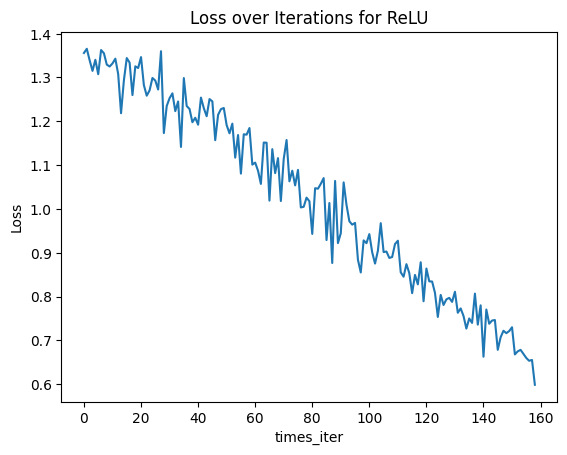

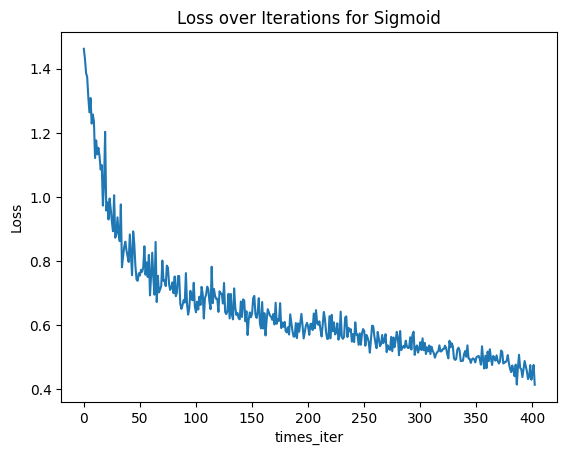

In [ ]:
plt.plot(losses1)
plt.xlabel('times_iter')
plt.ylabel('Loss')
plt.title('Loss over Iterations for ReLU')
plt.show()
plt.plot(losses2)
plt.xlabel('times_iter')
plt.ylabel('Loss')
plt.title('Loss over Iterations for Sigmoid')
plt.show()

***Some comments by choosing two different activation function:***

***Let me use the notion of 'convergence'.***

***By using ReLU function, we see the machine learn at the same rate on the same iteration intervals, though there maybe some fluctuations in one specific interval, meaning that it converges to truth at the same speed. However, when using Sigmoid function, we see the machine learn at a very rapid pace, but it will slow down its pace to study, extremely similar to Ebbinghaus Forgetting Curve.***

***Then we compare two functions. Without confusion, neutral network using ReLU converges more rapidly to the optimal result than that using Sigmoid function in this problem. Simply compare the number of iterations of two functions, approximately 160 and 400 times respectively.***